### Importaciones

In [14]:
import sys
import utils
import copy
from naive_bayes import NaiveBayes
import id3
from tabulate import tabulate

### Lectura de datos "Autism-Adult-Data.arff"

In [15]:
examples = utils.read_file('Autism-Adult-Data.arff')
data_set = examples[0]  # Datos
metadata = examples[1]  # Metadatos

### Constantes

In [16]:
target_attr = 'Class/ASD'
attributes = ['A1_Score', 'A2_Score','A3_Score','A4_Score','A5_Score', 'A6_Score','A7_Score', 'A8_Score','A9_Score',
              'A10_Score','age','gender','ethnicity','jundice','austim','contry_of_res','used_app_before','age_desc',
              'relation']
categorical_atts = ['A1_Score','A2_Score','A3_Score','A4_Score','A5_Score','A6_Score','A7_Score','A8_Score','A9_Score',
                    'A10_Score','gender','ethnicity','jundice','austim','contry_of_res','used_app_before','age_desc',
                    'relation']
non_categorical_atts = ['age']
weight = []
categorical_atts_indexes = [0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18]
non_categorical_atts_indexes = [10]

### Transformación de datos
A continuanción se procedere a transformar los datos. En primer lugar se busca desaparecer las instancias con valores faltante, para eso se remplaza los valores faltantes por el valor mas común en el atributo. En segundo lugar se procede a transformar los distintos tipos de valores a valores númericos, debido a que regresión logística opera con valores numéricos. Para realizar esto se aplica one hot encoding a los datos.

In [17]:
# Se usa most-common para manejar los missing values
data = utils.process_missing_values(data_set, attributes, True)
# Decode bytes
data = utils.decode_data(data)

# Extraemos el target attribute
data_ext, data_target_attributes = utils.extract_target_attributes(data)

# one hot encoding
numeric_data = utils.one_hot_encoding(data_ext, categorical_atts, 
                                      categorical_atts_indexes, non_categorical_atts, 
                                      non_categorical_atts_indexes)
numeric_attributes = list(numeric_data[0].keys())

# Insertamos target attribute
utils.insert_target_attributes(numeric_data, target_attr, data_target_attributes)

### Normalización
Se normalizan los valores numéricos utilizando la técnica de min_max: se re escalan los valores a un rango entre 0 y 1
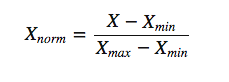
El re escalamiento se ejecuta en tiempo de entrenamiento, y el conjunto de validación se re escala utilizando los mismos parámetros (min y max) que se calcularon previamente.


In [18]:
#  Se divide el conjunto de datos
numeric_validation_set, numeric_training_set = utils.split_20_80(numeric_data)


# Normalizamos el training set utilizando la tecnica min-max
training_set_scaled, scalation_parameters = utils.scale(copy.deepcopy(numeric_training_set), 
                                                        numeric_attributes,use_standarization)

# Normalizamos el validation set utilizando la tecnica min-max y
# los valores que usamos para normalizar el training
validation_set_scaled = []
for instance in numeric_validation_set:
    scaled_instance = utils.scale_instance(copy.deepcopy(instance), scalation_parameters, use_standarization)
    validation_set_scaled.append(scaled_instance)

### Búsqueda de mejores parametros iniciales
Para aplicar regresión logística se requiere definir dos parámetros, uno es el weight y otro es el alpha.
El vector de weight es el que se debe ajustar durante el algorimo de regresión logística y este es fundamental para clasificar las instancias. Partiendo de un buen weight inicial se acelera la convergencia. Con el vector weight se realiza un producto escalar con el vector transformado de las instancias, este resultado es aplicado a la funcion sigmoide para obtener la hipótesis de clasificación.
Por el otro lado, el parámetro alpha se utiliza en el descenso por gradiente y representa el tamaño de intervalo en que una iteración de regresión logística se mueve en dirección del gradiente, con un alpha muy grande se corre el riesgo de no converger y con un alpha muy chico se puede tardar mucho en converger. Encontrar un alpha óptimo mejora el rendimiento del algoritmo.

Para hayar los mejores valores se prueba el vector weight con los siguientes valores 10, 1, 0.1 y 0, y para alphas los valores 50, 10, 1 y 0.5. Alpha no puede ser "0" debido a que esto implica que el intervalo que avanza el algorimo es cero, lo que genera que no se actualizen los pesos weight.

Para determinar cual es la mejor combinacion de valores se aplica regresión lógica a un conjunto de entrenamiento, la combinación que luego de 10 ajustes de weight logre el menor valor de la función costo es la que se usará en los siguientes bloques de código.

Antes de realizar la busqueda de los parametros mencionados se debió normalizar los atributos de las instancias de lo contrario el algoritmo no funcionaría. Este comportamiento es debido a que si los atributos no estan normalizados, cuando se realiza el producto escalar entre el vector weight y la instancia, se da como resultado un número muy grande o muy chico, cuando se evalúa en la función sigmoide (para obtener ho(x)), dado a la representación de los números de una máquina se obtiene 0 o 1 en vez de un valor muy aproximado. Cuando se calcula la funcion Cost dependiendo del valor de atributo objetivo se realiza log(ho(x)) o log(1-ho(x)), lo que genera que se termine computando log(0) lo cual no existe. Al normalizar, el producto entre el vector weight y la instancia (wTx) no produce un resultado extremo y la funcion sigmoide no devuelve 0 o 1, pudiendo realizarse el algoritmo correctamente.

In [19]:
bestChoose = []
posiblesWeight = [10, 1, 0.1, 0]
posiblesAlpha = [50, 10, 1, 0.5]
use_standarization = False


# Se agrega 1 al inicio de los datos para
# que el producto escalar tenga termino sesgo
LR_numeric_attributes = copy.deepcopy(numeric_attributes)
LR_numeric_attributes.insert(0,'sesgo')
LR_training_set_scaled = copy.deepcopy(training_set_scaled)
utils.insert_sesgo_one(LR_training_set_scaled)

print("Se realizan pruebas para obtiener los parametros con mejores resultados:")
tablaParametros = []
tablaParametros.append(["Weight", "Alpha", "Costo obtenido"])

# Se inicializa el costo mínimo como inf (máximo float)
minCost = float('inf')

for w in range(4):
    for a in range(4):
        weight= []
        
        # Array de Weights para LR
        for i in range(len(LR_numeric_attributes)):
            weight += [posiblesWeight[w]]

        # Constante alpha de LR
        alpha = posiblesAlpha[a]

        for i in range(10):
            # Se ajusta Weight con decenso por gradiente 10 veces
            weight = utils.descentByGradient(weight, LR_training_set_scaled, alpha, LR_numeric_attributes, target_attr)

        cost = utils.costFunction(weight, LR_training_set_scaled, LR_numeric_attributes, target_attr)
        tablaParametros.append([posiblesWeight[w], alpha, cost])

        if (minCost > cost):
            minCost = cost
            bestChoose = [posiblesWeight[w], posiblesAlpha[a], cost]

print(tabulate(tablaParametros, headers='firstrow', tablefmt='fancy_grid', stralign='right', showindex=True))
print("El menor costo conseguido fue: ", bestChoose[2], " con Weight = ", bestChoose[0], " y alpha = ", bestChoose[1])
print("A continuación se utilizarán los parametros obtenidos.")
print()


Se realizan pruebas para obtiener los parametros con mejores resultados:


KeyboardInterrupt: 

### Regresión lógica y comparación de resultado
A continuacion se realizan 10 iteraciones de los algoritmos regresión lógica, KNN, Naive Bayes y ID3 entrenando con el 80% del conjunto de datos y validando con el 20% restante.
En el caso de regresión lógica se utilizan los parametros encontrados en el segmento de codigo anterior.
Finalmente se presenta la comparativa de promedio de errores de los cuatro algoritmos.

In [ ]:
errors_LR_total = 0
errors_KNN_total = 0
errors_NB_total = 0
errors_ID3_total = 0

tablaIteraciones = []
tablaErroresIteraciones = []

tablaIteraciones.append(['','',"Iter 1","Iter 2","Iter 3","Iter 4","Iter 5","Iter 6","Iter 7","Iter 8"])
tablaErroresIteraciones.append(['','',"Iter 1","Iter 2","Iter 3","Iter 4","Iter 5","Iter 6","Iter 7","Iter 8","Promedio"])

for iter in range(8):
    print('Realizando iteración ',iter +1, ':')
    #######################################################################################
    #######################       Regresión Logica           ##############################
    #######################################################################################
    
    # Se divide el conjunto de datos
    numeric_validation_set, numeric_training_set = utils.split_20_80(numeric_data)


    use_standarization = False
    # Normalizamos el training set utilizando la tecnica min-max
    training_set_scaled, scalation_parameters = utils.scale(copy.deepcopy(numeric_training_set), numeric_attributes,use_standarization)


    # Normalizamos el validation set utilizando la tecnica min-max y
    # los valores que usamos para normalizar el training
    validation_set_scaled = []
    for instance in numeric_validation_set:
        scaled_instance = utils.scale_instance(copy.deepcopy(instance), scalation_parameters, use_standarization)
        validation_set_scaled.append(scaled_instance)


    # Se agrega 1 al inicio de los datos para
    # que el producto escalar tenga termino sesgo
    LR_numeric_attributes = copy.deepcopy(numeric_attributes)
    LR_numeric_attributes.insert(0,'sesgo')
    LR_training_set_scaled = copy.deepcopy(training_set_scaled)
    LR_validation_set_scaled = copy.deepcopy(validation_set_scaled)
    utils.insert_sesgo_one(LR_training_set_scaled)
    utils.insert_sesgo_one(LR_validation_set_scaled)

    # Weights para LR
    weight = []
    for i in range(len(LR_numeric_attributes)):
        weight += [bestChoose[0]]

    # Constante alpha de LR
    alpha = bestChoose[1]

    # Costo anterior
    cost = float('inf')

    # La condición de parado son 15 iteraciones o una 
    # diferencia de costos menor a 0.0001
    for i in range(15):
        newCost = utils.costFunction(weight, LR_training_set_scaled, LR_numeric_attributes, target_attr)
        dif =abs(cost - newCost)
        
        if (iter == 0):
            row = 'Ajuste ' + repr(i)
            tablaIteraciones.append([row])

        tablaIteraciones[i+1].append(newCost)
        
        if (abs(cost - newCost) < 0.0001):
            break
        cost = newCost
        weight = utils.descentByGradient(weight, LR_training_set_scaled, alpha, LR_numeric_attributes, target_attr)
    
    
    # LR holdout validation
    errors_LR = utils.LR_holdout_validation(LR_validation_set_scaled, target_attr, weight, LR_numeric_attributes)
    errors_LR_total += errors_LR


    #######################################################################################
    #######################               KNN                ##############################
    #######################################################################################
    
    # KNN holdout validation con k = 3 y usando pesos
    errors_KNN = utils.KNN_holdout_validation(copy.deepcopy(training_set_scaled), copy.deepcopy(validation_set_scaled), target_attr, numeric_attributes, 3, True)
    errors_KNN_total += errors_KNN[1]

    
    #######################################################################################
    #######################         Naive Bayes              ##############################
    #######################################################################################
    
    nb_classifier = NaiveBayes(copy.deepcopy(training_set_scaled), numeric_attributes, target_attr)
    errors_NB = nb_classifier.holdout_validation(copy.deepcopy(validation_set_scaled), target_attr)
    errors_NB_total += errors_NB[1]

    
    #######################################################################################
    #######################            ID3                   ##############################
    #######################################################################################
    
    tree = id3.ID3_algorithm(training_set_scaled, numeric_attributes, target_attr, True, False)
    errors_ID3 = id3.validation(tree, validation_set_scaled, target_attr)
    errors_ID3_total += errors_ID3

    if (iter == 0):
        tablaErroresIteraciones.append(['Regresión lógica'])
        tablaErroresIteraciones.append(['KNN'])
        tablaErroresIteraciones.append(['Naive Bayes'])
        tablaErroresIteraciones.append(['ID3'])

    tablaErroresIteraciones[1].append(errors_LR)
    tablaErroresIteraciones[2].append(errors_KNN[1])
    tablaErroresIteraciones[3].append(errors_NB[1])
    tablaErroresIteraciones[4].append(errors_ID3)

tablaErroresIteraciones[1].append(errors_LR_total/8)
tablaErroresIteraciones[2].append(errors_KNN_total/8)
tablaErroresIteraciones[3].append(errors_NB_total/8)
tablaErroresIteraciones[4].append(errors_ID3_total/8)

print(tabulate(tablaIteraciones, headers='firstrow', tablefmt='fancy_grid', stralign='right', showindex=True))
print()
print(tabulate(tablaErroresIteraciones, headers='firstrow', tablefmt='fancy_grid', stralign='right', showindex=True))